same assumptions of ship detection

# System design Assumptions
- small antenna area 0.3 m x 2 m
- Low Peak Power ~ 200 W i.e. 1/6 Synspective
- High Duty cycle (to compensate for the low peak power) ~ 25%
- Losses + Noise Figure = 10dB (conservative)
- Resolution Area < 2m^2 (like terraSar spotlight)
- Pfa <= 10^-6 i.e. less than 1 fa for NZ EEZ
- 30 m x 7 m vessels to be detected
- LEO = 500 km


In [115]:
# antenna
la = 2  # m
wa = .3  # m
# losses + Nf
losses = 10  # dB
# orbit
h = 500e3  # m
# bandwidth
B = 100e6  #Hz
# duty cycle
dutycycle = 0.25
# power
P_peak = 200  # W
pavg = dutycycle * P_peak  # W
# frequency
freq = 10e9
# wavelength
wavel = 299792458.0 / freq
# speed of light
c = 299792458.0

# AASR_min
aasrmin = -18  # dB

print('P_avg: ', pavg)

P_avg:  50.0


In [116]:
# dependencies
import numpy as np
from design_functions import *
import matplotlib.pyplot as plt
import matplotlib
from timing_diagram import time_diagram_plotter
from radartools.farField import UniformAperture
from spherical_earth_geometry_radar import *
from scipy.optimize import fsolve, bisect
from ambiguity_functions import *

matplotlib.use('Qt5Agg')
%matplotlib widget

# II unambiguous swath design algorithm
1. set the swath to the nominal one and choose the PRF without considering the duty cycle
2. allign PRF to closest valid timing diagram point
3. Evaluate the NESZ and correct the looking angle to recenter the beam
4. Reduce Bp till the AASR becomes smaller than a minumum value
5. Re evaluate NESZ and Ambiguities



In [117]:
theta = 23 # deg (incidence angle)

In [118]:
# radar and antenna models
# geometry
radGeo = RadarGeometry()
# looking angle
looking_angle = incidence_angle_to_looking_angle(theta * np.pi / 180, h)
radGeo.set_rotation(looking_angle, 0, 0)
# altitude
radGeo.set_initial_position(0, 0, h)
# orbital speed
v_s = radGeo.orbital_speed()
radGeo.set_speed(v_s)
print('looking_angle: ', looking_angle * 180 / np.pi, 'deg')
print('orbital speed:', v_s, 'm/s')
# ideal aperture antenna
uniap = UniformAperture(la, wa, freq)

looking_angle:  21.241377545068648 deg
orbital speed: [7612.68398988] m/s


1. SWATH

In [119]:
# elevation limits approx
el_width = wavel / wa * 1
# 3 dB beamwidth approx
inc_3dB = np.array((theta * np.pi / 180 - el_width / 2, theta * np.pi / 180 + el_width / 2))
# slant range from angles
swath_s, swath_g = range_from_theta(inc_3dB * 180 / np.pi, h)
swath_0 = swath_s[1] - swath_s[0]
# PRI without considering duty cycle
PRI_0 = 2 * swath_0 / c
print('initial prf guess', 1 / PRI_0)
print(swath_s)

initial prf guess 7135.631913551124
[529973.90962251 550980.63065521]


2. allign PRF

In [120]:
# alligning the PRI to fast time axis
# # step 1 impulse order determination
# average slant range
rs = np.average(swath_s)
order = np.floor(2 * rs / (PRI_0 * c))

# # step 2 adjusted PRI
PRI_1 = 2 * rs / (c * (.5 + order))

# # step 3 adjusted near end and far end range and swath
r2s1 = order * c * PRI_1 / 2
r1s1 = (order + 1) * c * PRI_1 / 2

# # step 4 adjusted ground ranges
r1g1, theta1 = range_slant_to_ground(r1s1)
r2g1, theta2 = range_slant_to_ground(r2s1)
rg1 = r1g1 - r2g1

## updated swath
swath_s = np.array([r2s1, r1s1])
swath_g0 = np.array([r2g1, r1g1])
inc_swat = np.array([theta2, theta1])

In [121]:
print(swath_s)
print(swath_g0)
print(inc_swat * 180 / np.pi)
print('refined PRF guess:', 1 / PRI_1)

[529879.67660673 551074.863671  ]
[168922.59328037 223118.948912  ]
[20.10692133 25.88495137]
refined PRF guess: 7072.182403744615


In [122]:
theta_1, PRI_2, swath_g = closest_nadir_null(PRI_1, swath_s[0], h, end='near')

print("Corrected PRF = ", 1 / PRI_2)
print('Corrected Ground Range', swath_g)
# new slant range
swath_s = range_ground_to_slant(swath_g, h)
# new incidence range
swath_g, inc_swat = range_slant_to_ground(swath_s, h)
print(inc_swat * 180 / np.pi)

# dutycycle limits
usable_swath_s = swath_s + np.array([dutycycle * PRI_2 * c / 2, - dutycycle * PRI_2 * c / 2])
usable_swath_g, usable_inc = range_slant_to_ground(usable_swath_s, h)
# set the incidence angle in the middle of the usable swath
theta_1 = np.average(usable_inc * 180 / np.pi)

print('Usable ground swath: ', usable_swath_g, usable_swath_g[1] - usable_swath_g[0])
print('Corrected broadside Incidence angle:', theta_1)

Corrected PRF =  7195.018992
Corrected Ground Range [140429.84701434 200618.29456664]
[16.90358856 23.53900428]
Usable ground swath:  [157406.17324985 187190.48929432] 29784.316044472827
Corrected broadside Incidence angle: 20.463849482306898


In [123]:
# adjust radar looking angle
looking_angle = incidence_angle_to_looking_angle(theta_1 / 180 * np.pi, h)
radGeo.set_rotation(looking_angle, 0, 0)

(array([ 1.,  0., -0.]),
 array([ 0.        , -0.94599717,  0.32417488]),
 array([ 0.        , -0.32417488, -0.94599717]))

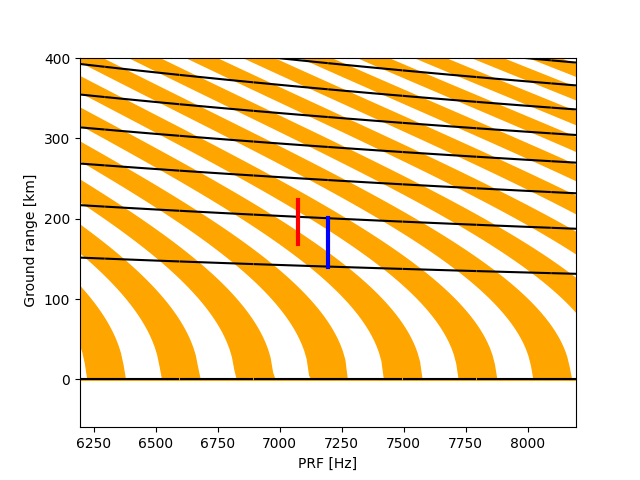

In [124]:
# timing diagram
prf = np.linspace(1 / PRI_2 - 1000, 1 / PRI_2 + 1000, 200)
# plotting
fig, ax = plt.subplots(1)
time_diagram_plotter(ax, prf, dutycycle, h)
ax.set_xlabel('PRF [Hz]')
ax.set_ylabel(' Ground range [km]')
ax.set_ylim(swath_g[0] / 1000 - 200, swath_g[1] / 1000 + 200)
ax.set_xlim(1 / PRI_2 - 1000, 1 / PRI_2 + 1000)

# design point
prff = np.abs(np.ones_like(swath_g) / PRI_2)
ax.plot(prff, swath_g / 1000, 'b', linewidth=3)
# PREVIOUS DESIGN POINT
prff = np.abs(np.ones_like(swath_g0) / PRI_1)
ax.plot(prff, swath_g0 / 1000, 'r', linewidth=3)

3. Evaluate NESZ and recenter the beam

In [125]:
# incidence angle axis
incidence = np.linspace(usable_inc[0], usable_inc[1], 51)
# NESZ_core, aximuth resolution using nominal doppler bandwidth
SNR_core, daz = core_snr_spherical(radGeo, uniap, incidence, wavel, v_s, h)
# nominal doppler bandwidth for reference
Bd = nominal_doppler_bandwidth(la, np.average(usable_inc) * np.pi / 180, wavel, v_s, h)
print("nominal Doppler Bandwidth:", Bd, 'Hz')

nominal Doppler Bandwidth: [7613.30827945] Hz


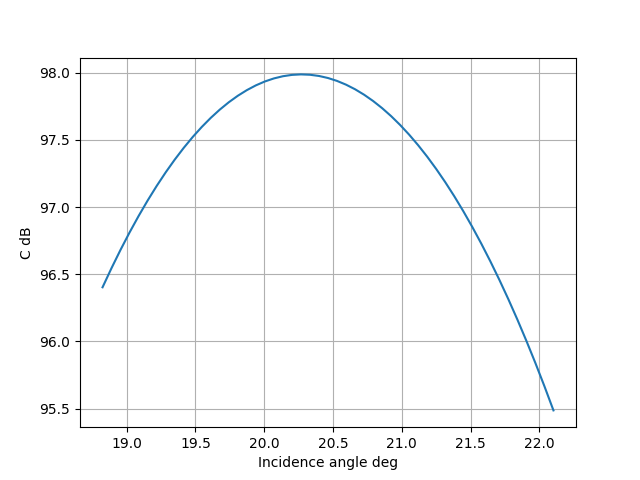

In [126]:
# core SNR plot
fig, ax = plt.subplots(1)
rs, rg = range_from_theta(incidence * 180 / np.pi, h)
ax.plot(incidence * 180 / np.pi, 10 * np.log10(SNR_core))
ax.set_xlabel('Incidence angle deg')
ax.set_ylabel('C dB')
ax.grid()

Parametrized NESZ
\begin{equation}
    NESZ = \dfrac{F\ L \ T_a\ B_n}{C\ P_{av}}
\end{equation}

In [127]:
Ta = 300  # k
NESZ = 10 ** (losses / 10) * Ta * B / (SNR_core * pavg)

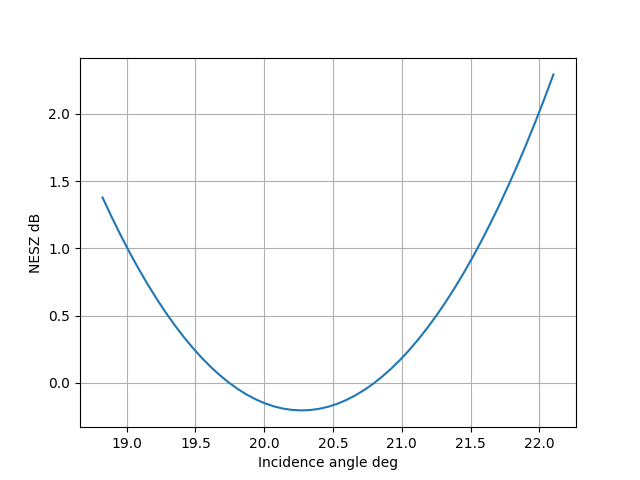

In [128]:
# NESZ plotting
fig, ax = plt.subplots(1)
rs, rg = range_from_theta(incidence * 180 / np.pi, h)
ax.plot(incidence * 180 / np.pi, 10 * np.log10(NESZ))
ax.set_xlabel('Incidence angle deg')
ax.set_ylabel('NESZ dB')
ax.grid()

3. correct the looking angle

In [129]:
# optimization

beta_opt = fsolve(lambda b: snr_error(b, usable_inc[0], usable_inc[1], radGeo, uniap), looking_angle, maxfev=1000)
beta_opt * 180 / np.pi
# recenter radar
radGeo.set_rotation(beta_opt, 0, 0)
re=6371e3
bs_inc = np.arcsin((re + h) / re * np.sin(beta_opt))
print(bs_inc*180/np.pi)

[20.64479703]


recentered beam

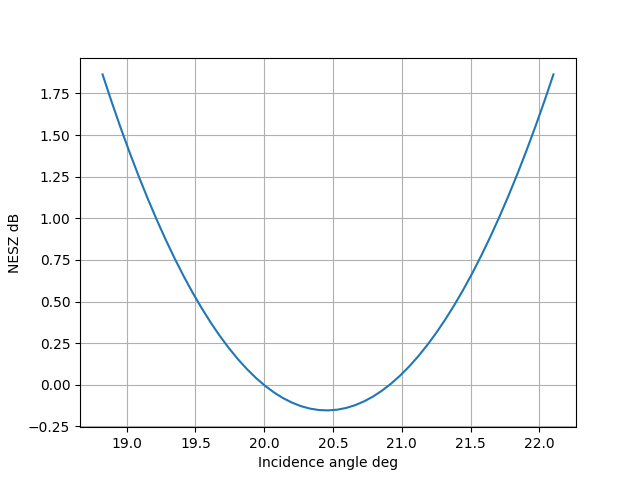

In [130]:
SNR_core, daz = core_snr_spherical(radGeo, uniap, incidence, wavel, v_s, h)
NESZ = 10 ** (losses / 10) * Ta * B / (SNR_core * pavg)
fig, ax = plt.subplots(1)
rs, rg = range_from_theta(incidence * 180 / np.pi, h)
ax.plot(incidence * 180 / np.pi, 10 * np.log10(NESZ))
ax.set_xlabel('Incidence angle deg')
ax.set_ylabel('NESZ dB')
ax.grid()

4. Reduce Bp till the AASR becomes smaller than a minumum value

In [131]:
# what's the undersampling ratio?
print(Bd * PRI_2)
# what's the AASR now?
aasr = AASR(radGeo, uniap, np.average(usable_inc) * 180 / np.pi, 1 / PRI_2, Bd, wavel)
print('AASR= ', 10 * np.log10(aasr))

[1.05813595]


100%|██████████| 65/65 [00:01<00:00, 37.94it/s]

AASR=  [0.22515774]


In [132]:
# optimize processed doppler bandwidth for aasr
fractional = fsolve(
    lambda p: AASR(radGeo, uniap, np.average(usable_inc) * 180 / np.pi, 1 / PRI_2, Bd * p, wavel, pbaroff=True) - 10 ** (
                aasrmin / 10), 1, maxfev=20)

In [133]:
print(fractional)
print(Bd)
print(1/PRI_2)

[0.53591225]
[7613.30827945]
7195.018992


In [134]:
# what's the undersampling ratio?
print(Bd * PRI_2) # this is not the undersampling ratio
# what's the AASR now?
aasr = AASR(radGeo, uniap, np.average(usable_inc) * 180 / np.pi, 1 / PRI_2, Bd*fractional, wavel)
print('AASR= ', 10 * np.log10(aasr))

[1.05813595]


100%|██████████| 65/65 [00:02<00:00, 32.30it/s]

AASR=  [-17.86130442]


5. Re evaluate NESZ and Ambiguities

In [135]:
# NESZ with reduced doppler bandwidth
SNR_core, daz = core_snr_spherical(radGeo, uniap, incidence, wavel, v_s, h, Bd_scaling=fractional)
NESZ = 10 ** (losses / 10) * Ta * B / (SNR_core * pavg)


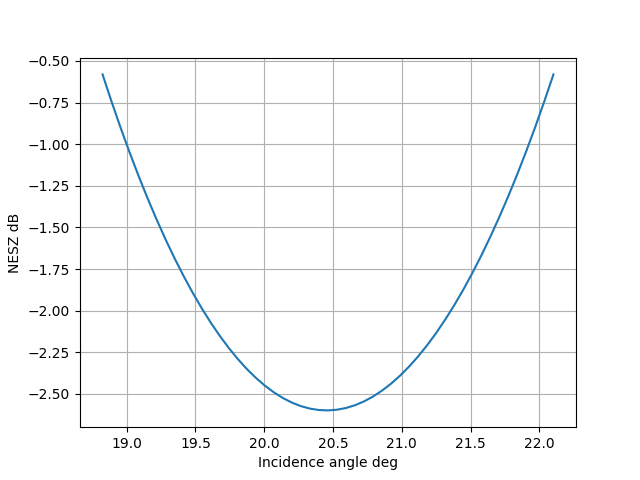

In [136]:
fig, ax = plt.subplots(1)
rs, rg = range_from_theta(incidence * 180 / np.pi, h)
ax.plot(incidence * 180 / np.pi, 10 * np.log10(NESZ))
ax.set_xlabel('Incidence angle deg')
ax.set_ylabel('NESZ dB')
ax.grid()

In [137]:
# Azimuth resolution
print(np.average(daz))
1/fractional

1.7294152482886231


array([1.86597711])

In [138]:
# RASR
rasr = RASR(radGeo, uniap, incidence, PRI_2, Bd*fractional, wavel, v_s)

100%|██████████| 99/99 [00:04<00:00, 21.40it/s]


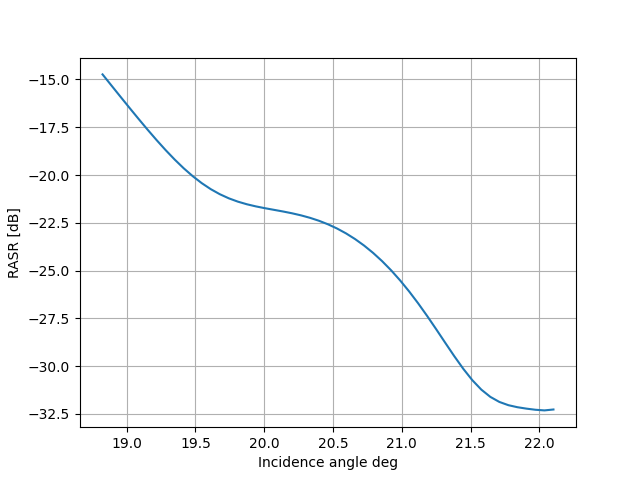

In [139]:
# plotting
fig, ax = plt.subplots(1)
rs, rg = range_from_theta(incidence * 180 / np.pi, h)
ax.plot(incidence * 180 / np.pi, 10 * np.log10(rasr))
ax.set_xlabel('Incidence angle deg')
ax.set_ylabel('RASR [dB]')
ax.grid()


Using matplotlib backend: module://ipympl.backend_nbagg


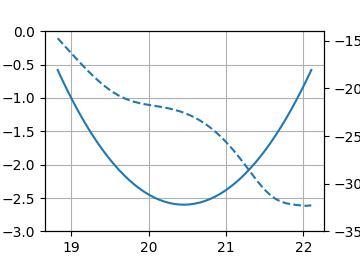

In [140]:
# two azis plot
%matplotlib
plt.rcParams['svg.fonttype'] = 'none'
fig, ax = plt.subplots(1)
fig.set_size_inches(3.6, 2.6, forward=True)
rs, rg = range_from_theta(incidence * 180 / np.pi, h)
ax.plot(incidence * 180 / np.pi, 10 * np.log10(NESZ))
ax.set_xlabel('Incidence angle [deg]')
ax.set_ylabel('NESZ [dB] ---')
ax.grid()
ax.set_ylim(-3,0)
# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(incidence * 180 / np.pi, 10 * np.log10(rasr),'--')
ax2.set_ylabel("RASR - - -")
ax2.set_ylim(-35,-14)
plt.savefig('.\\psifig.svg')
plt.show()
#plt.close('all')

In [143]:
print(range_from_theta(22,500e3))
print(range_from_theta(19,500e3))


(536101.2939703864, 186239.4943967446)
(526548.2614684956, 158969.13962022806)


In [144]:
186239.4943967446 - 158969.13962022806


27270.354776516528